# $\S$ 6.1. One-Dimensional Kernel Smoothers

In Chapter 2, we motivated the $k$-nearest-neighbor average

\begin{equation}
\hat{f}(x) = \text{Ave}\left( y_i|x_i\in N_k(x) \right)
\end{equation}

as an estimate of the regression function $\text{E}(Y|X=x)$. The idea is to relax the definition of conditional expectation, as illustrated in the left panel of FIGURE 6.1, and compute an average in a neighborhood of the target point.

The KNN average changes in a discrete way, leading to a discontinuous $\hat{f}$, which is ugly and unnecessary.

In [1]:
%matplotlib inline
import scipy
import matplotlib.pyplot as plt

# K-nearest neighbors (Section 2.3)
def knn(k: int, point:float,
        data_x:scipy.ndarray, data_y:scipy.ndarray) -> float:
    idx_sorted = scipy.argsort((data_x-point)*(data_x-point))[:k]
    return data_y[idx_sorted].mean()

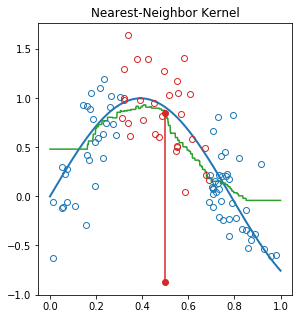

In [2]:
"""FIGURE 6.1. (The left panel) The result of 30-NN running-mean smoother
The green curve is bumpy, since the 30-NN average is discontinuous."""
xgrid = scipy.linspace(0, 1, 1001)
y_true = scipy.sin(4*xgrid)

size_sample = 100
x_sample = scipy.random.uniform(size=size_sample)
y_sample = scipy.sin(4*x_sample) + scipy.randn(size_sample)/3

idx_x0 = 500
x0 = xgrid[idx_x0]  # .5
idx_x0_neighbors = scipy.argsort((x_sample-x0)*(x_sample-x0))

k = 30
y_knn = scipy.array([knn(k, x, x_sample, y_sample) for x in xgrid])

fig61 = plt.figure(61, figsize=(10, 5))
ax1 = fig61.add_subplot(1, 2, 1)
ax1.plot(xgrid, y_true, color='C0', linewidth=2)
ax1.plot(xgrid, y_knn, color='C2')
ax1.plot(x_sample[idx_x0_neighbors[:30]], y_sample[idx_x0_neighbors[:30]],
         'o', color='C3', mfc='none')
ax1.plot(x_sample[idx_x0_neighbors[30:]], y_sample[idx_x0_neighbors[30:]],
         'o', color='C0', mfc='none')
ax1.plot((x0, x0), (ax1.get_ylim()[0], y_knn[idx_x0]), 'o-', color='C3')
ax1.set_title('Nearest-Neighbor Kernel')
plt.show()

### Kernel-weighted average

> Rather than give all the points in the neighborhood equal weight, we can assign weights that die off smoothly with distance from the target point.

The right panel shows an example of this, using the so-called Nadaraya-Watson kernel-weighted average

\begin{equation}
\hat{f}(x_0) = \frac{\sum_{i=1}^N K_\lambda(x_0, x_i)y_i}{\sum_{i=1}^N K_\lambda(x_0, x_i)},
\end{equation}

with the _Epanechnikov_ quadratic kernel

\begin{equation}
K_\lambda(x_0,x) = D \left( \frac{|x-x_0|}\lambda \right),
\end{equation}

with

\begin{equation}
D(t) = \begin{cases}
\frac34 (1-t^2) & \text{if } |t| \le 1; \\
0 & \text{otherwise}.
\end{cases}
\end{equation}

In [3]:
"""FIGURE 6.1. (The right panel) The kernel-weighted average using an Epanechnikov kernel
with (half) window width lambda=0.2."""
def Epanechnikov(lmbda:float, point:float,
                 data_x:scipy.ndarray, data_y:scipy.ndarray) -> float:
    t = scipy.absolute(data_x-point)/lmbda  # argment for D
    k = scipy.where(t <= 1, .75*(1-t), 0)
    return (k @ data_y).sum()/k.sum()

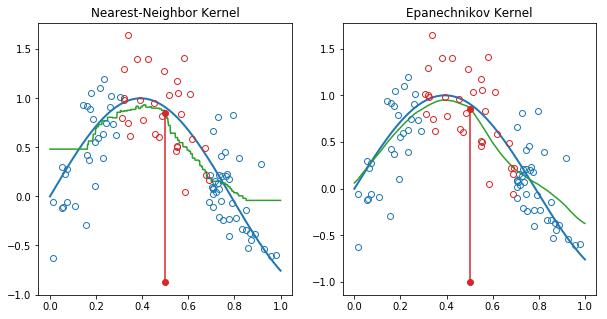

In [4]:
lmbda = .2
y_knn_weighted = scipy.array([Epanechnikov(lmbda, x, x_sample, y_sample)
                              for x in xgrid])

mask_neighbor = scipy.absolute(x_sample-x0)/lmbda <= 1

ax2 = fig61.add_subplot(1, 2, 2)
ax2.plot(xgrid, y_true, color='C0', linewidth=2)
ax2.plot(xgrid, y_knn_weighted, color='C2')
ax2.plot(x_sample[~mask_neighbor], y_sample[~mask_neighbor], 'o', color='C0', mfc='none')
ax2.plot(x_sample[mask_neighbor], y_sample[mask_neighbor],
         'o', color='C3', mfc='none')
ax2.plot((x0, x0), (ax1.get_ylim()[0], y_knn[idx_x0]), 'o-', color='C3')
ax2.set_title('Epanechnikov Kernel')
fig61

The fitted function is now continuous, and quite smooth in the right panel. As we move the target from left to right, points enter the neighborhood initially with weight zero, and then their contribution slowly increases (see Exercise 6.1).

Note that we used a metric window size $\lambda=0.2$ for the kernel fit, which does not change as we move the target point $x_0$, while the size of the 30-NN smoothing window adapts to the local density of the $x_i$. One can, however, also use such adaptive neighborhoods with kernels, but we need to use a more general notation.

\begin{equation}
K_\lambda(x_0, x) = D \left( \frac{|x-x_0|}{h_\lambda(x_0)} \right),
\end{equation}

where $h_\lambda(x_0)$ is a width function (indexed by $\lambda$) that determines the width of the neighborhood at $x_0$.

* The Epanechnikov kernel uses a constant $h_\lambda(x_0)=\lambda$.
* KNN replaces $\lambda$ with the neighborhood size $k$, and we have

  \begin{equation}
  h_k(x_0) = |x_0 - x_{[k]}|,
  \end{equation}
  
  where $x_{[k]}$ is the $k$th closest $x_i$ to $x_0$.

### Some implications

* The smoothing parameter $\lambda$, which determines the width of the local neighborhood, has to be determined.
  * Large $\lambda$ implies lower variance -- averages over more observations,  
  * but higher bias -- we essentially assume the true functionis constant within the window.

* Metric window widths (constant $h_\lambda(x)$) tend to keep the bias of the estimate constant, but the variance is inversely proportional to the local density.  
  Nearest-neighbor window width exhibit the oppoite behavior; the variance stays constant and the absolute bias varies inversely with local density.

* Issues arise with nearest-neighbors when there are ties in the $x$. With most smoothing techniques one can simply reduce the data set by averaging the $y_i$ at tied values of $X$, and supplementing these new observations at the unique values of $x_i$ with an additional weight $w_i$ (which multiples the kernel weight).

* This leaves a more general problem to deal with: Observation wieghts $w_i$.  
  Operationally we simply multiply them by the kernel weights before computing the weighted average. With nearest neighborhoods, it is now natural to insist on neighborhoods with a total weight content $k$ (relative to $\sum w_i$).  
  In the event of overflow (the last observation needed in a neighborhood has a weight $w_j$, which causes the sum of weights to exceed the budget $k$), then fractional parts can be used.

* Boundary issues arise. The metric neighborhoods tend to contain less points on the boundaries, while the nearest-neighborhoods get wider.

* The Epanechnikov kernel has compact support (needed when used with nearest-neighbor window size). Another popular compact kernel is based on the tri-cube function

  \begin{equation}
  D(t) = \begin{cases}
  (1-|t|^3)^3 & \text{ if } |t| \le 1;\\
  0 & \text{otherwise}.
  \end{cases}
  \end{equation}
  
  This is
  * flatter on top (like the nearest-neighbor box) and
  * differentiable at the boundary of its support.
  
  The Gaussian density function $D(t) = \phi(t)$ is a popular noncompact kernel, with standard deviation playing the role of the window size. See FIGURE 6.2 in the textbook.